In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
X_train = pd.read_csv('../datasets/scaled_train_test/X_train_standard.csv', delimiter=',')
X_test = pd.read_csv('../datasets/scaled_train_test/X_test_standard.csv', delimiter=',')
y_train = X_train['Value (kWh)']
y_test = X_test['Value (kWh)']
X_train.drop(['Value (kWh)'], axis=1, inplace=True)
X_test.drop(['Value (kWh)'], axis=1, inplace=True)

In [3]:
X_test.columns

Index(['Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind speed (m/s)', 'Global radiation (W/m2)', 'Wind_direction',
       'Cloud_amount_binary', 'Precipitation_binary', 'hour_of_day',
       'day_of_year', 'solar_elev_angle', 'sun_azimuth',
       'TheoreticalSolarRadiation'],
      dtype='object')

In [4]:
import tensorflow as tf
keras = tf.keras
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

We will split the X_train data further into X_train and X_val, which is going to be our validation set.

In [8]:
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.8) 

Let's find the appropriate learning rate for this NN architecture

In [10]:
nn = keras.models.Sequential()
nn.add(keras.layers.Dense(300, activation='relu', input_shape=X_train_v.shape[1:]))
nn.add(keras.layers.Dense(200, activation='relu'))
nn.add(keras.layers.Dense(100, activation='relu'))
nn.add(keras.layers.Dense(1))
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
nn.compile(optimizer=optimizer, loss='mean_squared_error')

In [11]:
history = nn.fit(X_train_v,y_train_v, epochs=100,
                 validation_data=(X_val,y_val),
                callbacks=[lr_schedule, reset_states])

Epoch 1/100
212/212 [==============================] - 1s 4ms/step - loss: 1.0735 - val_loss: 1.0626 - lr: 1.0000e-08
Epoch 2/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0733 - val_loss: 1.0625 - lr: 1.1220e-08
Epoch 3/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0732 - val_loss: 1.0624 - lr: 1.2589e-08
Epoch 4/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0730 - val_loss: 1.0622 - lr: 1.4125e-08
Epoch 5/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0728 - val_loss: 1.0620 - lr: 1.5849e-08
Epoch 6/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0726 - val_loss: 1.0618 - lr: 1.7783e-08
Epoch 7/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0724 - val_loss: 1.0615 - lr: 1.9953e-08
Epoch 8/100
212/212 [==============================] - 1s 3ms/step - loss: 1.0721 - val_loss: 1.0612 - lr: 2.2387e-08
Epoch 9/100
212/212 [==============================] - 1

Epoch 70/100
212/212 [==============================] - 1s 3ms/step - loss: 0.1091 - val_loss: 0.1071 - lr: 2.8184e-05
Epoch 71/100
212/212 [==============================] - 1s 3ms/step - loss: 0.1048 - val_loss: 0.1031 - lr: 3.1623e-05
Epoch 72/100
212/212 [==============================] - 1s 3ms/step - loss: 0.1015 - val_loss: 0.1000 - lr: 3.5481e-05
Epoch 73/100
212/212 [==============================] - 1s 3ms/step - loss: 0.0989 - val_loss: 0.0976 - lr: 3.9811e-05
Epoch 74/100
212/212 [==============================] - 1s 3ms/step - loss: 0.0967 - val_loss: 0.0955 - lr: 4.4668e-05
Epoch 75/100
212/212 [==============================] - 1s 3ms/step - loss: 0.0947 - val_loss: 0.0937 - lr: 5.0119e-05
Epoch 76/100
212/212 [==============================] - 1s 3ms/step - loss: 0.0932 - val_loss: 0.0923 - lr: 5.6234e-05
Epoch 77/100
212/212 [==============================] - 1s 3ms/step - loss: 0.0918 - val_loss: 0.0910 - lr: 6.3096e-05
Epoch 78/100
212/212 [==========================

Read the proper learning rate, typically at the elbow of the graph.

(1e-08, 0.001, 0.0, 2.0)

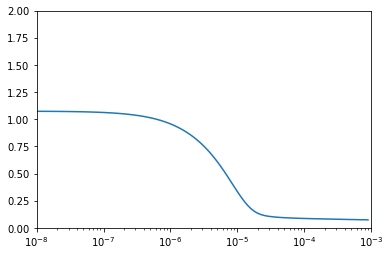

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0,2])

Selected learning rate: __1e-5__

Training the model for 500 epochs

#### Training NN model
The model will be training for maximum 500 epochs, saving itself each time it improves in __'my_checkpoint.h5'__. If there is no more improvement for the next 50 epochs, the __EarlyStopping__ callback will finish the training and use the checkpointed best model. 

In [13]:
nn = keras.models.Sequential()
nn.add(keras.layers.Dense(300, activation='relu', input_shape=X_train_v.shape[1:]))
nn.add(keras.layers.Dense(200, activation='relu'))
nn.add(keras.layers.Dense(100, activation='relu'))
nn.add(keras.layers.Dense(1))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
nn.compile(optimizer=optimizer, loss='mean_squared_error')
nn.fit(X_train_v,y_train_v, epochs=500, steps_per_epoch=200,
                                          validation_data=(X_val,y_val),
                                          validation_steps=50, callbacks=[early_stopping, model_checkpoint, reset_states])


Epoch 1/500
200/200 [==============================] - 0s 2ms/step - loss: 0.9030 - val_loss: 0.8281
Epoch 2/500
200/200 [==============================] - 0s 2ms/step - loss: 0.7724 - val_loss: 0.7092
Epoch 3/500
200/200 [==============================] - 0s 2ms/step - loss: 0.6606 - val_loss: 0.6080
Epoch 4/500
200/200 [==============================] - 0s 1ms/step - loss: 0.5663 - val_loss: 0.5222
Epoch 5/500
200/200 [==============================] - 0s 1ms/step - loss: 0.4847 - val_loss: 0.4486
Epoch 6/500
200/200 [==============================] - 0s 1ms/step - loss: 0.4153 - val_loss: 0.3865
Epoch 7/500
200/200 [==============================] - 0s 1ms/step - loss: 0.3542 - val_loss: 0.3343
Epoch 8/500
200/200 [==============================] - 0s 2ms/step - loss: 0.3092 - val_loss: 0.2913
Epoch 9/500
200/200 [==============================] - 0s 2ms/step - loss: 0.2739 - val_loss: 0.2563
Epoch 10/500
200/200 [==============================] - 0s 1ms/step - loss: 0.2367 - val_lo

Epoch 161/500
200/200 [==============================] - ETA: 0s - loss: 0.085 - 0s 1ms/step - loss: 0.0848 - val_loss: 0.0855
Epoch 162/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0826 - val_loss: 0.0855
Epoch 163/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0867 - val_loss: 0.0854
Epoch 164/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0854
Epoch 165/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0871 - val_loss: 0.0854
Epoch 166/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0853
Epoch 167/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.0853
Epoch 168/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0852
Epoch 169/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0852
Epoch 170/500
200/200 [==========================

200/200 [==============================] - 0s 1ms/step - loss: 0.0835 - val_loss: 0.0827
Epoch 241/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0827
Epoch 242/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0838 - val_loss: 0.0827
Epoch 243/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0802 - val_loss: 0.0826
Epoch 244/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0832 - val_loss: 0.0826
Epoch 245/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0812 - val_loss: 0.0826
Epoch 246/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0785 - val_loss: 0.0826
Epoch 247/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0830 - val_loss: 0.0825
Epoch 248/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0825 - val_loss: 0.0825
Epoch 249/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0810 - v

200/200 [==============================] - 0s 1ms/step - loss: 0.0774 - val_loss: 0.0796
Epoch 399/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0772 - val_loss: 0.0796
Epoch 400/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0796
Epoch 401/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0769 - val_loss: 0.0796
Epoch 402/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0795
Epoch 403/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.0795
Epoch 404/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0771 - val_loss: 0.0795
Epoch 405/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0764 - val_loss: 0.0795
Epoch 406/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0795
Epoch 407/500
200/200 [==============================] - 0s 1ms/step - loss: 0.0766 - v

In [14]:
model = keras.models.load_model("my_checkpoint.h5")

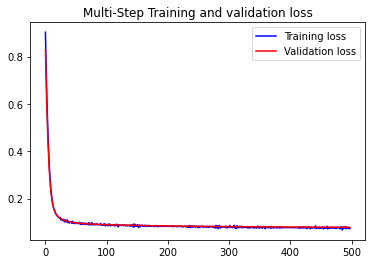

In [15]:
plot_train_history(nn.history, 'Multi-Step Training and validation loss')

### Validation set

In [9]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    print('Model Performance')
    print('mse: {}'.format(mean_squared_error(y, y_pred)))
    print('rmse: {}'.format(sqrt(mean_squared_error(y, y_pred))))
    print('r2: {}'.format(r2_score(y, y_pred)))

Evaluation on training data

In [17]:
evaluate(model,X_train_v,y_train_v)

Model Performance
mse: 0.07561683644412925
rmse: 0.2749851567705596
r2: 0.9246526738526679


Evaluation on validation data

In [18]:
evaluate(model,X_val,y_val)

Model Performance
mse: 0.07830634792102381
rmse: 0.27983271417227795
r2: 0.9216226747187711


Evaluation on test data

In [22]:
evaluate(model,X_test,y_test)

Model Performance
mse: 0.07918314708241903
rmse: 0.2813950018788874
r2: 0.9197296453407274


#### Test data

Text(0.5, 1.0, 'Evaluation of Neural Network Predictions')

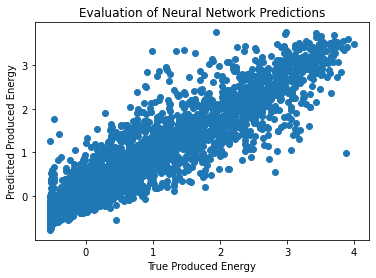

In [25]:
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Neural Network Predictions')

Text(0.5, 1.0, 'Error distribution')

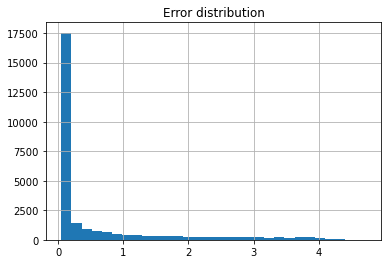

In [26]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_val - model.predict(X_val)[0]
errors.hist(bins=30)
plt.title('Error distribution')

The random forests 'off the shelf' before even tuning the parameters showed beter results. We get back to hyperparameter tuning in the next update. Meanwhile this code below here will be left as a placeholder.

## Hyperparameter tuning for Neural Networks with Keras and Scikit-learn
Neural networks are very flexible in terms of their architecture, which is, consequently, one of their drawbacks. There are just numerous combinations of hyperparameters to tweak and choose from. Even in simple Multi Layer Perceptron (MLP) that we used, one can change the number of layers, the number of neurons per layer, types of activation functions, etc.

We will create a function which would sum up our model and use a keras scikit-learn wrapper to 'wrap' the model as if it is a scikit-learn regressor which we can later use with RandomizedSearchCV.

In [10]:
def build_model(n_hidden,n_neurons, learning_rate=1e-5,input_shape=[len(X_train.columns)]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [11]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

In [13]:
param_dist = {
    'n_hidden': [1,2,3],
    'n_neurons': [100,200,300]
}

In [14]:
nn_search_cv = RandomizedSearchCV(keras_reg, param_dist, n_iter=10, cv=3)
nn_search_cv.fit(X_train_v,y_train_v, epochs=100,
                 validation_data=(X_val,y_val),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

c:\users\screwdriver\desktop\github\solar_prod_suvilahti\solar_env\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1814 - val_loss: 1.1980
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1600 - val_loss: 1.1765
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1392 - val_loss: 1.1555
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1188 - val_loss: 1.1350
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0990 - val_loss: 1.1150
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0796 - val_loss: 1.0955
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0606 - val_loss: 1.0764
Epoch 8/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0421 - val_loss: 1.0578
Epoch 9/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0241 - val_loss: 1.0395
Epoch 10/100
141/141 [==============================] - 0s 3ms/step - loss: 1.0064 - val_lo

141/141 [==============================] - 1s 4ms/step - loss: 0.3784 - val_loss: 0.3844
Epoch 82/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3745 - val_loss: 0.3804
Epoch 83/100
141/141 [==============================] - 0s 4ms/step - loss: 0.3707 - val_loss: 0.3765
Epoch 84/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3670 - val_loss: 0.3727
Epoch 85/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3634 - val_loss: 0.3690
Epoch 86/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3598 - val_loss: 0.3653
Epoch 87/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3563 - val_loss: 0.3617
Epoch 88/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3528 - val_loss: 0.3582
Epoch 89/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3495 - val_loss: 0.3547
Epoch 90/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3462 - val_loss: 

Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4136 - val_loss: 0.4116
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4088 - val_loss: 0.4069
Epoch 63/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4041 - val_loss: 0.4023
Epoch 64/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3995 - val_loss: 0.3978
Epoch 65/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3949 - val_loss: 0.3934
Epoch 66/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3905 - val_loss: 0.3891
Epoch 67/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3862 - val_loss: 0.3849
Epoch 68/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3819 - val_loss: 0.3807
Epoch 69/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3777 - val_loss: 0.3766
Epoch 70/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3736

141/141 [==============================] - 0s 3ms/step - loss: 0.6457 - val_loss: 0.6395
Epoch 41/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6372 - val_loss: 0.6313
Epoch 42/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6289 - val_loss: 0.6234
Epoch 43/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6208 - val_loss: 0.6156
Epoch 44/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6128 - val_loss: 0.6079
Epoch 45/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6049 - val_loss: 0.6004
Epoch 46/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5972 - val_loss: 0.5930
Epoch 47/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5897 - val_loss: 0.5858
Epoch 48/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5823 - val_loss: 0.5787
Epoch 49/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5750 - val_loss: 

Epoch 20/100
141/141 [==============================] - 0s 4ms/step - loss: 0.7707 - val_loss: 0.7872
Epoch 21/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7586 - val_loss: 0.7750
Epoch 22/100
141/141 [==============================] - 0s 4ms/step - loss: 0.7468 - val_loss: 0.7631
Epoch 23/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7352 - val_loss: 0.7514
Epoch 24/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7239 - val_loss: 0.7400
Epoch 25/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7128 - val_loss: 0.7287
Epoch 26/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7019 - val_loss: 0.7178
Epoch 27/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6912 - val_loss: 0.7070
Epoch 28/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6808 - val_loss: 0.6965
Epoch 29/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6705

71/71 [==============================] - 0s 481us/step - loss: 0.3035
Epoch 1/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8322 - val_loss: 0.8204
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8180 - val_loss: 0.8068
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8042 - val_loss: 0.7934
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7907 - val_loss: 0.7803
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7775 - val_loss: 0.7675
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7645 - val_loss: 0.7550
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7519 - val_loss: 0.7427
Epoch 8/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7395 - val_loss: 0.7307
Epoch 9/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7273 - val_loss: 0.7190
Epoch 10/100
141/141 

Epoch 80/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2879 - val_loss: 0.2909
Epoch 81/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2852 - val_loss: 0.2882
Epoch 82/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2826 - val_loss: 0.2856
Epoch 83/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2800 - val_loss: 0.2830
Epoch 84/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2774 - val_loss: 0.2805
Epoch 85/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2749 - val_loss: 0.2781
Epoch 86/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2725 - val_loss: 0.2756
Epoch 87/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2701 - val_loss: 0.2733
Epoch 88/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2677 - val_loss: 0.2710
Epoch 89/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2654

141/141 [==============================] - 0s 3ms/step - loss: 0.4382 - val_loss: 0.4374
Epoch 60/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4322 - val_loss: 0.4316
Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4262 - val_loss: 0.4260
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4204 - val_loss: 0.4204
Epoch 63/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4148 - val_loss: 0.4150
Epoch 64/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4092 - val_loss: 0.4097
Epoch 65/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4038 - val_loss: 0.4045
Epoch 66/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3985 - val_loss: 0.3994
Epoch 67/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3933 - val_loss: 0.3944
Epoch 68/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3882 - val_loss: 

Epoch 39/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5093 - val_loss: 0.5193
Epoch 40/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 0.5112
Epoch 41/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5033
Epoch 42/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4859 - val_loss: 0.4957
Epoch 43/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4784 - val_loss: 0.4882
Epoch 44/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4712 - val_loss: 0.4808
Epoch 45/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4641 - val_loss: 0.4737
Epoch 46/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4572 - val_loss: 0.4667
Epoch 47/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4504 - val_loss: 0.4599
Epoch 48/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4438

141/141 [==============================] - 0s 3ms/step - loss: 0.8583 - val_loss: 0.8319
Epoch 19/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8418 - val_loss: 0.8163
Epoch 20/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8258 - val_loss: 0.8010
Epoch 21/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8102 - val_loss: 0.7861
Epoch 22/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7949 - val_loss: 0.7715
Epoch 23/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7800 - val_loss: 0.7573
Epoch 24/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7655 - val_loss: 0.7435
Epoch 25/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7513 - val_loss: 0.7300
Epoch 26/100
141/141 [==============================] - 0s 3ms/step - loss: 0.7375 - val_loss: 0.7168
Epoch 27/100
141/141 [==============================] - 0s 4ms/step - loss: 0.7240 - val_loss: 

141/141 [==============================] - 0s 3ms/step - loss: 0.2639 - val_loss: 0.2630
Epoch 99/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2613 - val_loss: 0.2605
Epoch 100/100
71/71 [==============================] - 0s 486us/step - loss: 0.2486
Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2469 - val_loss: 1.2110
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 1.2232 - val_loss: 1.1883
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 1.2001 - val_loss: 1.1662
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1775 - val_loss: 1.1447
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1554 - val_loss: 1.1236
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1339 - val_loss: 1.1031
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 1.1129 - val_loss: 1.0830
Epoch 8/100
141/14

Epoch 78/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3736 - val_loss: 0.3768
Epoch 79/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3692 - val_loss: 0.3727
Epoch 80/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3649 - val_loss: 0.3685
Epoch 81/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3607 - val_loss: 0.3645
Epoch 82/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3566 - val_loss: 0.3606
Epoch 83/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3526 - val_loss: 0.3567
Epoch 84/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3486 - val_loss: 0.3530
Epoch 85/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3448 - val_loss: 0.3492
Epoch 86/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3410 - val_loss: 0.3456
Epoch 87/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3373

141/141 [==============================] - 0s 3ms/step - loss: 0.6177 - val_loss: 0.6339
Epoch 58/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6093 - val_loss: 0.6254
Epoch 59/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6011 - val_loss: 0.6170
Epoch 60/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5930 - val_loss: 0.6088
Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5850 - val_loss: 0.6007
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5772 - val_loss: 0.5927
Epoch 63/100
141/141 [==============================] - 0s 4ms/step - loss: 0.5695 - val_loss: 0.5849
Epoch 64/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5619 - val_loss: 0.5772
Epoch 65/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5545 - val_loss: 0.5697
Epoch 66/100
141/141 [==============================] - 0s 3ms/step - loss: 0.5472 - val_loss: 

Epoch 37/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8325 - val_loss: 0.8205
Epoch 38/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8248 - val_loss: 0.8130
Epoch 39/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8172 - val_loss: 0.8056
Epoch 40/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8097 - val_loss: 0.7984
Epoch 41/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8024 - val_loss: 0.7912
Epoch 42/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7951 - val_loss: 0.7842
Epoch 43/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7879 - val_loss: 0.7772
Epoch 44/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7809 - val_loss: 0.7703
Epoch 45/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7739 - val_loss: 0.7636
Epoch 46/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7670

141/141 [==============================] - 1s 4ms/step - loss: 0.9295 - val_loss: 0.9124
Epoch 17/100
141/141 [==============================] - 0s 3ms/step - loss: 0.9200 - val_loss: 0.9032
Epoch 18/100
141/141 [==============================] - 0s 3ms/step - loss: 0.9107 - val_loss: 0.8941
Epoch 19/100
141/141 [==============================] - 0s 3ms/step - loss: 0.9014 - val_loss: 0.8851
Epoch 20/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8923 - val_loss: 0.8762
Epoch 21/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8832 - val_loss: 0.8674
Epoch 22/100
141/141 [==============================] - 0s 4ms/step - loss: 0.8743 - val_loss: 0.8587
Epoch 23/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8655 - val_loss: 0.8501
Epoch 24/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8568 - val_loss: 0.8417
Epoch 25/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8481 - val_loss: 

141/141 [==============================] - 0s 3ms/step - loss: 0.4248 - val_loss: 0.4223
Epoch 97/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4208 - val_loss: 0.4185
Epoch 98/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4169 - val_loss: 0.4147
Epoch 99/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4131 - val_loss: 0.4110
Epoch 100/100
71/71 [==============================] - 0s 505us/step - loss: 0.4013
Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9768 - val_loss: 0.9926
Epoch 2/100
141/141 [==============================] - 0s 4ms/step - loss: 0.9652 - val_loss: 0.9810
Epoch 3/100
141/141 [==============================] - 0s 4ms/step - loss: 0.9538 - val_loss: 0.9695
Epoch 4/100
141/141 [==============================] - 0s 4ms/step - loss: 0.9426 - val_loss: 0.9582
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9315 - val_loss: 0.9471
Epoch 6/100
141/

Epoch 76/100
141/141 [==============================] - 0s 4ms/step - loss: 0.4293 - val_loss: 0.4394
Epoch 77/100
141/141 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4351
Epoch 78/100
141/141 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4308
Epoch 79/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4167 - val_loss: 0.4266
Epoch 80/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4126 - val_loss: 0.4224
Epoch 81/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4086 - val_loss: 0.4183
Epoch 82/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4047 - val_loss: 0.4143
Epoch 83/100
141/141 [==============================] - 0s 3ms/step - loss: 0.4007 - val_loss: 0.4103
Epoch 84/100
141/141 [==============================] - 0s 4ms/step - loss: 0.3969 - val_loss: 0.4063
Epoch 85/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3930

141/141 [==============================] - 1s 4ms/step - loss: 0.5388 - val_loss: 0.5327
Epoch 56/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5334 - val_loss: 0.5274
Epoch 57/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5280 - val_loss: 0.5221
Epoch 58/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5226 - val_loss: 0.5169
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5174 - val_loss: 0.5117
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5121 - val_loss: 0.5066
Epoch 61/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5070 - val_loss: 0.5016
Epoch 62/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5019 - val_loss: 0.4966
Epoch 63/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4969 - val_loss: 0.4917
Epoch 64/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4919 - val_loss: 

Epoch 35/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5537 - val_loss: 0.5475
Epoch 36/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5463 - val_loss: 0.5405
Epoch 37/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5391 - val_loss: 0.5336
Epoch 38/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5320 - val_loss: 0.5268
Epoch 39/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5250 - val_loss: 0.5201
Epoch 40/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5182 - val_loss: 0.5135
Epoch 41/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5114 - val_loss: 0.5070
Epoch 42/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5047 - val_loss: 0.5006
Epoch 43/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4982 - val_loss: 0.4944
Epoch 44/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4918

141/141 [==============================] - 1s 4ms/step - loss: 0.7945 - val_loss: 0.8097
Epoch 15/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7838 - val_loss: 0.7989
Epoch 16/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7732 - val_loss: 0.7883
Epoch 17/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7629 - val_loss: 0.7779
Epoch 18/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7527 - val_loss: 0.7676
Epoch 19/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7426 - val_loss: 0.7575
Epoch 20/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7327 - val_loss: 0.7475
Epoch 21/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7230 - val_loss: 0.7377
Epoch 22/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7134 - val_loss: 0.7281
Epoch 23/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7040 - val_loss: 

141/141 [==============================] - 1s 4ms/step - loss: 0.3063 - val_loss: 0.3152
Epoch 95/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3033 - val_loss: 0.3121
Epoch 96/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3004 - val_loss: 0.3091
Epoch 97/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2975 - val_loss: 0.3062
Epoch 98/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2947 - val_loss: 0.3033
Epoch 99/100
141/141 [==============================] - 1s 4ms/step - loss: 0.2919 - val_loss: 0.3004
Epoch 100/100
71/71 [==============================] - 0s 859us/step - loss: 0.2954
Epoch 1/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1549 - val_loss: 1.1210
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1354 - val_loss: 1.1025
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1164 - val_loss: 1.0844
Epoch 4/100
14

Epoch 74/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4351 - val_loss: 0.4342
Epoch 75/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4304 - val_loss: 0.4296
Epoch 76/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4257 - val_loss: 0.4251
Epoch 77/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4211 - val_loss: 0.4207
Epoch 78/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4166 - val_loss: 0.4164
Epoch 79/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4121 - val_loss: 0.4121
Epoch 80/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4077 - val_loss: 0.4078
Epoch 81/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4034 - val_loss: 0.4037
Epoch 82/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3992 - val_loss: 0.3996
Epoch 83/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3950

141/141 [==============================] - 1s 4ms/step - loss: 0.5446 - val_loss: 0.5412
Epoch 54/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5384 - val_loss: 0.5352
Epoch 55/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5323 - val_loss: 0.5293
Epoch 56/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5263 - val_loss: 0.5235
Epoch 57/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5204 - val_loss: 0.5178
Epoch 58/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5146 - val_loss: 0.5121
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5088 - val_loss: 0.5066
Epoch 60/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5031 - val_loss: 0.5010
Epoch 61/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4975 - val_loss: 0.4956
Epoch 62/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4920 - val_loss: 

Epoch 33/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7203 - val_loss: 0.7347
Epoch 34/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7141 - val_loss: 0.7285
Epoch 35/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7080 - val_loss: 0.7224
Epoch 36/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7021 - val_loss: 0.7164
Epoch 37/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6962 - val_loss: 0.7105
Epoch 38/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6904 - val_loss: 0.7046
Epoch 39/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6847 - val_loss: 0.6989
Epoch 40/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6790 - val_loss: 0.6932
Epoch 41/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6735 - val_loss: 0.6876
Epoch 42/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6680

141/141 [==============================] - 1s 4ms/step - loss: 0.8648 - val_loss: 0.8439
Epoch 13/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8592 - val_loss: 0.8386
Epoch 14/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8536 - val_loss: 0.8333
Epoch 15/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8481 - val_loss: 0.8281
Epoch 16/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8426 - val_loss: 0.8229
Epoch 17/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8371 - val_loss: 0.8178
Epoch 18/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8317 - val_loss: 0.8127
Epoch 19/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8264 - val_loss: 0.8076
Epoch 20/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8211 - val_loss: 0.8026
Epoch 21/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8158 - val_loss: 

141/141 [==============================] - 1s 4ms/step - loss: 0.5077 - val_loss: 0.5018
Epoch 93/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5040 - val_loss: 0.4982
Epoch 94/100
141/141 [==============================] - 1s 4ms/step - loss: 0.5003 - val_loss: 0.4946
Epoch 95/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4967 - val_loss: 0.4910
Epoch 96/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4930 - val_loss: 0.4875
Epoch 97/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4894 - val_loss: 0.4840
Epoch 98/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4858 - val_loss: 0.4805
Epoch 99/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4822 - val_loss: 0.4770
Epoch 100/100
71/71 [==============================] - 0s 539us/step - loss: 0.4500
Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 1.0218 - val_loss: 1.0069
Epoch 2/100


Epoch 72/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6819 - val_loss: 0.6750
Epoch 73/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6779 - val_loss: 0.6710
Epoch 74/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6738 - val_loss: 0.6671
Epoch 75/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6697 - val_loss: 0.6631
Epoch 76/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6657 - val_loss: 0.6592
Epoch 77/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6616 - val_loss: 0.6552
Epoch 78/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6513
Epoch 79/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6536 - val_loss: 0.6474
Epoch 80/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6496 - val_loss: 0.6435
Epoch 81/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6456

141/141 [==============================] - 1s 5ms/step - loss: 0.7231 - val_loss: 0.7385
Epoch 52/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7176 - val_loss: 0.7329
Epoch 53/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7120 - val_loss: 0.7273
Epoch 54/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7065 - val_loss: 0.7217
Epoch 55/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7010 - val_loss: 0.7161
Epoch 56/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6956 - val_loss: 0.7106
Epoch 57/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6902 - val_loss: 0.7051
Epoch 58/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6848 - val_loss: 0.6997
Epoch 59/100
141/141 [==============================] - 1s 4ms/step - loss: 0.6794 - val_loss: 0.6943
Epoch 60/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6741 - val_loss: 

Epoch 31/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7717 - val_loss: 0.7620
Epoch 32/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7649 - val_loss: 0.7553
Epoch 33/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7582 - val_loss: 0.7487
Epoch 34/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7515 - val_loss: 0.7422
Epoch 35/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7448 - val_loss: 0.7357
Epoch 36/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7382 - val_loss: 0.7292
Epoch 37/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7316 - val_loss: 0.7228
Epoch 38/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7251 - val_loss: 0.7164
Epoch 39/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7186 - val_loss: 0.7101
Epoch 40/100
141/141 [==============================] - 1s 4ms/step - loss: 0.7122

141/141 [==============================] - 1s 4ms/step - loss: 0.9245 - val_loss: 0.9112
Epoch 11/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9152 - val_loss: 0.9022
Epoch 12/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9061 - val_loss: 0.8933
Epoch 13/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8971 - val_loss: 0.8845
Epoch 14/100
141/141 [==============================] - 1s 5ms/step - loss: 0.8881 - val_loss: 0.8759
Epoch 15/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8793 - val_loss: 0.8673
Epoch 16/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8706 - val_loss: 0.8589
Epoch 17/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8620 - val_loss: 0.8505
Epoch 18/100
141/141 [==============================] - 1s 5ms/step - loss: 0.8535 - val_loss: 0.8423
Epoch 19/100
141/141 [==============================] - 1s 4ms/step - loss: 0.8451 - val_loss: 

141/141 [==============================] - 1s 4ms/step - loss: 0.4141 - val_loss: 0.4160
Epoch 91/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4098 - val_loss: 0.4119
Epoch 92/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4056 - val_loss: 0.4078
Epoch 93/100
141/141 [==============================] - 1s 4ms/step - loss: 0.4014 - val_loss: 0.4038
Epoch 94/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3972 - val_loss: 0.3997
Epoch 95/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3932 - val_loss: 0.3958
Epoch 96/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3891 - val_loss: 0.3919
Epoch 97/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3851 - val_loss: 0.3880
Epoch 98/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3811 - val_loss: 0.3841
Epoch 99/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3772 - val_loss: 

Epoch 70/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6092 - val_loss: 0.6228
Epoch 71/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6046 - val_loss: 0.6182
Epoch 72/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6001 - val_loss: 0.6136
Epoch 73/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5956 - val_loss: 0.6090
Epoch 74/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5911 - val_loss: 0.6045
Epoch 75/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5866 - val_loss: 0.5999
Epoch 76/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5822 - val_loss: 0.5954
Epoch 77/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5778 - val_loss: 0.5910
Epoch 78/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5734 - val_loss: 0.5865
Epoch 79/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5690

141/141 [==============================] - 1s 5ms/step - loss: 0.6107 - val_loss: 0.6046
Epoch 50/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6051 - val_loss: 0.5992
Epoch 51/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5995 - val_loss: 0.5938
Epoch 52/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5940 - val_loss: 0.5884
Epoch 53/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5885 - val_loss: 0.5831
Epoch 54/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5831 - val_loss: 0.5779
Epoch 55/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5777 - val_loss: 0.5726
Epoch 56/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5723 - val_loss: 0.5675
Epoch 57/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5670 - val_loss: 0.5623
Epoch 58/100
141/141 [==============================] - 1s 5ms/step - loss: 0.5617 - val_loss: 

Epoch 29/100
141/141 [==============================] - 1s 5ms/step - loss: 0.8365 - val_loss: 0.8193
Epoch 30/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8276 - val_loss: 0.8107
Epoch 31/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8188 - val_loss: 0.8022
Epoch 32/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8101 - val_loss: 0.7939
Epoch 33/100
141/141 [==============================] - 1s 6ms/step - loss: 0.8016 - val_loss: 0.7857
Epoch 34/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7932 - val_loss: 0.7776
Epoch 35/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7849 - val_loss: 0.7696
Epoch 36/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7768 - val_loss: 0.7618
Epoch 37/100
141/141 [==============================] - 1s 6ms/step - loss: 0.7687 - val_loss: 0.7541
Epoch 38/100
141/141 [==============================] - 1s 5ms/step - loss: 0.7608

212/212 [==============================] - 1s 3ms/step - loss: 0.7610 - val_loss: 0.7496
Epoch 9/100
212/212 [==============================] - 1s 2ms/step - loss: 0.7416 - val_loss: 0.7308
Epoch 10/100
212/212 [==============================] - 1s 3ms/step - loss: 0.7228 - val_loss: 0.7126
Epoch 11/100
212/212 [==============================] - 1s 3ms/step - loss: 0.7046 - val_loss: 0.6950
Epoch 12/100
212/212 [==============================] - 0s 2ms/step - loss: 0.6870 - val_loss: 0.6780
Epoch 13/100
212/212 [==============================] - 1s 2ms/step - loss: 0.6700 - val_loss: 0.6614
Epoch 14/100
212/212 [==============================] - 1s 3ms/step - loss: 0.6535 - val_loss: 0.6453
Epoch 15/100
212/212 [==============================] - 1s 2ms/step - loss: 0.6373 - val_loss: 0.6297
Epoch 16/100
212/212 [==============================] - 1s 3ms/step - loss: 0.6218 - val_loss: 0.6146
Epoch 17/100
212/212 [==============================] - 1s 2ms/step - loss: 0.6067 - val_loss: 0

212/212 [==============================] - 1s 3ms/step - loss: 0.1856 - val_loss: 0.1885
Epoch 89/100
212/212 [==============================] - 1s 3ms/step - loss: 0.1839 - val_loss: 0.1868
Epoch 90/100
212/212 [==============================] - 1s 3ms/step - loss: 0.1823 - val_loss: 0.1852
Epoch 91/100
212/212 [==============================] - 1s 2ms/step - loss: 0.1807 - val_loss: 0.1836
Epoch 92/100
212/212 [==============================] - 1s 2ms/step - loss: 0.1791 - val_loss: 0.1821
Epoch 93/100
212/212 [==============================] - 1s 2ms/step - loss: 0.1776 - val_loss: 0.1806
Epoch 94/100
212/212 [==============================] - 1s 2ms/step - loss: 0.1762 - val_loss: 0.1791
Epoch 95/100
212/212 [==============================] - 0s 2ms/step - loss: 0.1748 - val_loss: 0.1777
Epoch 96/100
212/212 [==============================] - 0s 2ms/step - loss: 0.1734 - val_loss: 0.1763
Epoch 97/100
212/212 [==============================] - 1s 2ms/step - loss: 0.1721 - val_loss: 

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001B02244DEE0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': [100, 200, 300]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [15]:
nn_search_cv.best_params_

{'n_neurons': 300, 'n_hidden': 1}

In [16]:
import pickle
nn_best_param = nn_search_cv.best_params_
pickle.dump(nn_best_param, open( "nn_best_param_CV.p", "wb" ) )

In [17]:
model = nn_search_cv.best_estimator_.model

Evaluation

In [18]:
evaluate(model,X_train_v,y_train_v)

Model Performance
mse: 0.16764820338812778
rmse: 0.4094486578169817
r2: 0.8329493211735621


Evaluation on validation data

In [19]:
evaluate(model,X_val,y_val)

Model Performance
mse: 0.17113987536671982
rmse: 0.41369055508522284
r2: 0.8287050023871041


Evaluation on test data

In [20]:
evaluate(model,X_test,y_test)

Model Performance
mse: 0.1692925335987598
rmse: 0.41145173908826754
r2: 0.8283830308109026


Text(0.5, 1.0, 'Evaluation of Neural Network Predictions')

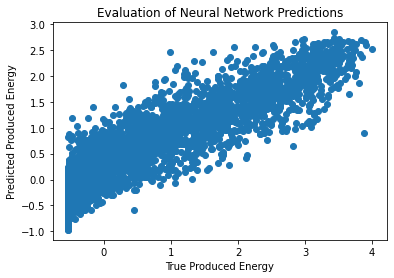

In [21]:
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Neural Network Predictions')

Text(0.5, 1.0, 'Error distribution')

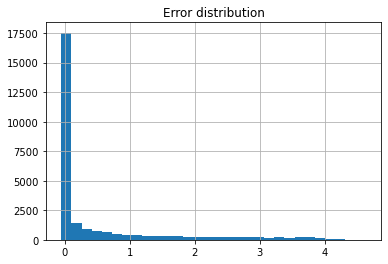

In [22]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_val - model.predict(X_val)[0]
errors.hist(bins=30)
plt.title('Error distribution')

Basically, there is a ton of possibilities to improve the NN model, such as tailormake the NN architecture, drop out some neurons, go deeper into the deep learning, etc. Since this is at a stage where other parts of this project need more attention and the result with RF is already satisfying, I will come back to this to explore other methods, such as a promising new "Cat Boost" library from Yandex, or improve the possible architectures of NN, etc., when I come up with an adequate test coverage for the deployed model.